In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load the Dataset

In [3]:
# Preprocessing steps
BASE_DIR = '../dataset/age-gender-recog-dataset'

In [4]:
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

100%|██████████| 23708/23708 [00:00<00:00, 222638.43it/s]


### Exploratory Data Analysis

In [5]:
# Convert to DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels
})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

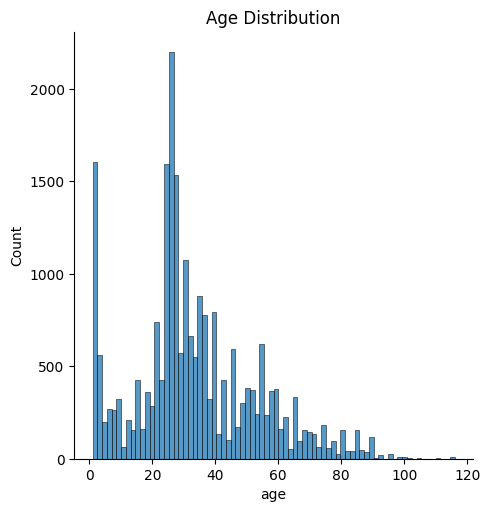

In [6]:
# Plot the age distribution
sns.displot(df['age'], kde=False)
plt.title("Age Distribution")
plt.show()

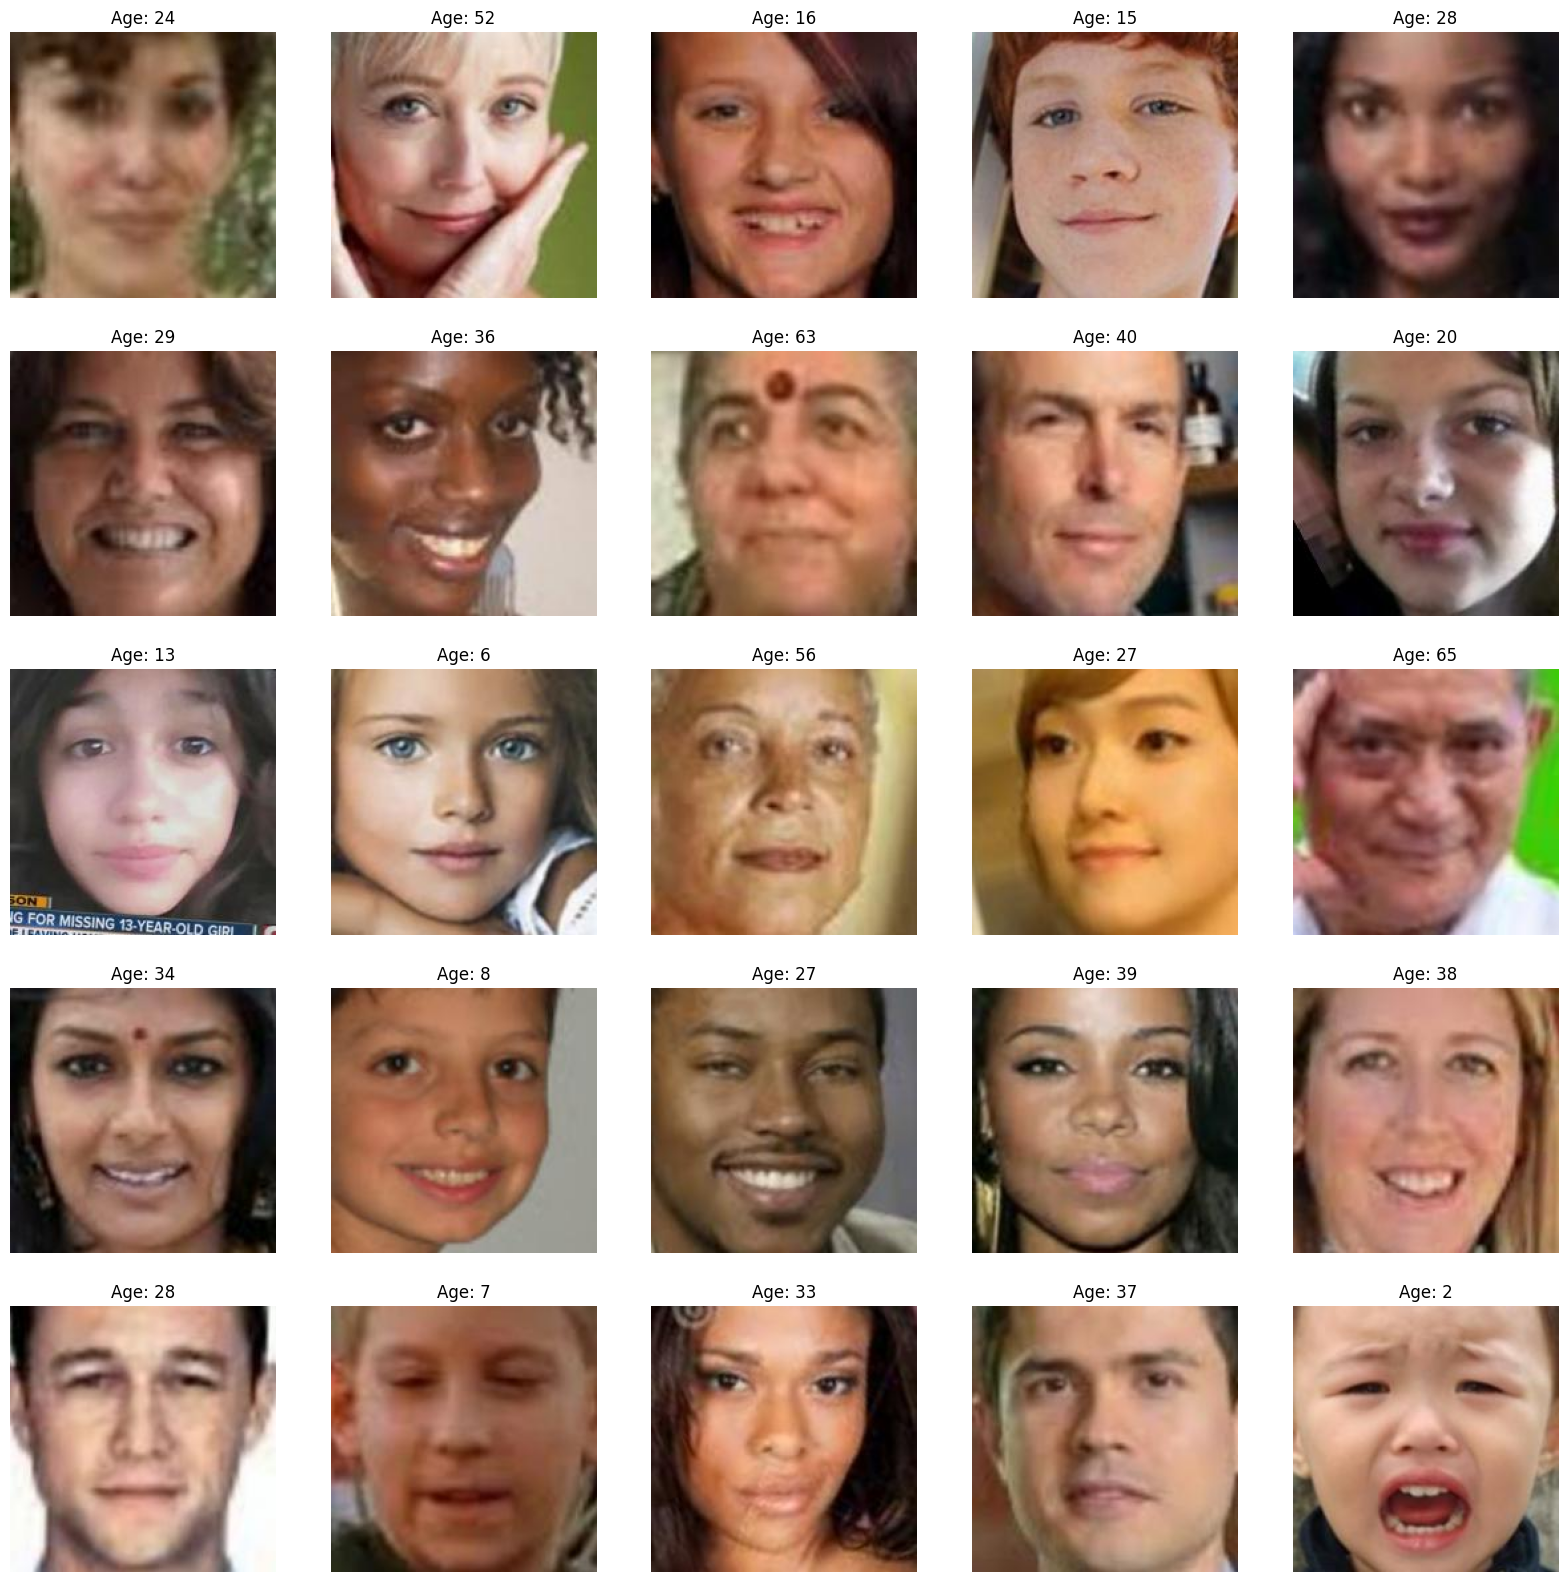

In [7]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

# Use plain tuples to access rows
for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)

    file = row[0]
    age = row[1]

    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

plt.show()

### Feature Extraction

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [9]:
X = extract_features(df['image'])
X = X / 255.0
y_age = np.array(df['age'])

100%|██████████| 23708/23708 [00:24<00:00, 971.11it/s] 


In [10]:
X.shape

(23708, 128, 128, 1)

### Training the model

In [11]:
# Manually split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_age, test_size=0.2, random_state=42)

In [12]:
# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# For validation, you typically don't want to augment the data, so use a simple generator
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

### Model Creation

In [33]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

# Define the convolutional layers for age prediction
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
batchnorm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(batchnorm_1)
dropout_conv_1 = Dropout(0.3)(maxp_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(batchnorm_2)
dropout_conv_2 = Dropout(0.3)(maxp_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)
dropout_conv_3 = Dropout(0.3)(maxp_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
batchnorm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)
dropout_conv_4 = Dropout(0.3)(maxp_4)

conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu')(dropout_conv_4)
batchnorm_5 = BatchNormalization()(conv_5)
maxp_5 = MaxPooling2D(pool_size=(2, 2))(batchnorm_5)
dropout_conv_5 = Dropout(0.3)(maxp_5)

flatten = Flatten()(dropout_conv_5)

# Fully connected layers with L2 regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)
batchnorm_dense_1 = BatchNormalization()(dense_1)
dropout_1 = Dropout(0.4)(batchnorm_dense_1)

output_2 = Dense(1)(dropout_1)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('../models/best_age_model.keras', monitor='val_loss', save_best_only=True)
]

In [34]:
# Apply the generators to the training set
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
593/593 [==============================] - 25s 40ms/step - loss: 1396.5299 - mae: 32.8005 - val_loss: 1015.6533 - val_mae: 27.6198 - lr: 1.0000e-04
Epoch 2/100
593/593 [==============================] - 23s 39ms/step - loss: 1176.7827 - mae: 30.9024 - val_loss: 806.5029 - val_mae: 23.1316 - lr: 1.0000e-04
Epoch 3/100
593/593 [==============================] - 23s 38ms/step - loss: 962.5215 - mae: 27.7161 - val_loss: 864.0911 - val_mae: 23.4457 - lr: 1.0000e-04
Epoch 4/100
593/593 [==============================] - 23s 39ms/step - loss: 707.6385 - mae: 23.0363 - val_loss: 766.1859 - val_mae: 21.1994 - lr: 1.0000e-04
Epoch 5/100
593/593 [==============================] - 23s 39ms/step - loss: 469.2144 - mae: 17.7392 - val_loss: 1037.8636 - val_mae: 25.6678 - lr: 1.0000e-04
Epoch 6/100
593/593 [==============================] - 23s 39ms/step - loss: 299.5380 - mae: 13.3212 - val_loss: 348.1886 - val_mae: 13.0665 - lr: 1.0000e-04
Epoch 7/100
593/593 [===========================

##### Execution Time with GPU: 19m 36.4s

### Plot the results

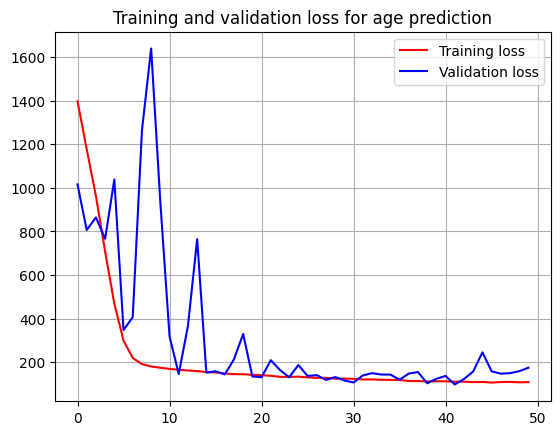

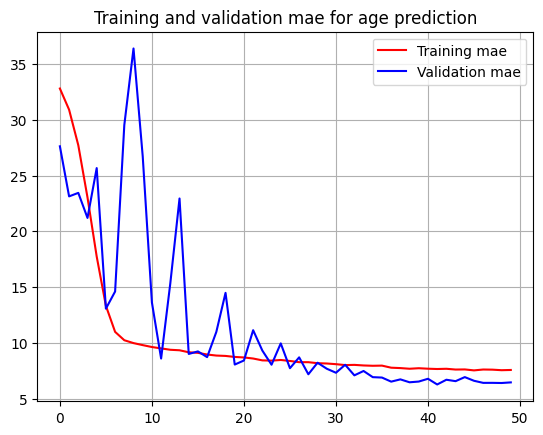

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
# plot results for age
loss = history.history.get('loss', history.history.get('loss'))
val_loss = history.history.get('val_loss', history.history.get('val_loss'))

epochs = range(len(loss))

# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for age prediction')
plt.legend()
plt.grid()
plt.show()
plt.figure()

# plot results for age
mae = history.history.get('mae', history.history.get('mae'))
val_mae= history.history.get('val_mae', history.history.get('val_mae'))

epochs = range(len(mae))

# Plot training and validation mae
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae for age prediction')
plt.legend()
plt.grid()
plt.show()
plt.figure()

In [36]:
# Access validation MAE from the training history
val_age_mae = history.history['val_mae'][-1]
print(f"Validation Mean Absolute Error for Age Prediction: {val_age_mae:.2f}")

Validation Mean Absolute Error for Age Prediction: 6.46


### Prediction with Test Data

Original Age:  65
1/1 [==============================] - 0s 233ms/step
Predicted Age: 63-69


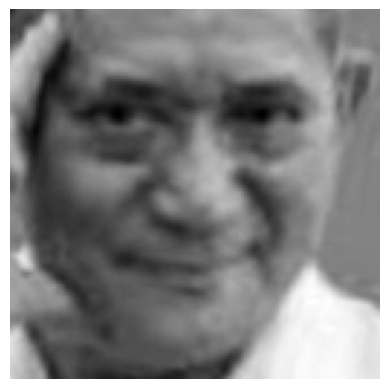

In [37]:
# Age Prediction Code with Post-Processing
image_index = 14
print("Original Age: ", y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age_value = pred[0][0]

# Ensure age is not less than 1 and predict a range
pred_age_value = max(1, pred_age_value)
range_width = max(2, int(0.05 * pred_age_value))  # 5% of predicted age, with a minimum range of 2
pred_age_lower = max(1, round(pred_age_value - range_width))  # Lower bound
pred_age_upper = round(pred_age_value + range_width)  # Upper bound

print(f"Predicted Age: {pred_age_lower}-{pred_age_upper}")

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()